<font size="5"> **Mixed layer depth in the Southern Ocean** </font>  
  
This script loads model-derived MLD data and plots the Mixed Layer Depth (MLD) and plots de Mixed Layer Depth for different sectors of the Southern Ocean using the IAF cycle 3 output from ACCESS-OM2-01. 
  
**Requirements:** It is suggested you use the `conda/analysis3-24.01` (or later). This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a code cell.

This script is a simplified version of this code https://github.com/lidefi87/ACCESS_scripts_DFA/blob/main/Scripts/Stephy/MLD_calc_Denisse.ipynb
made by Denisse Fierro Arcos that was posted as a issue on ACCESS-hive. 

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import os
from glob import glob
import re
from collections import OrderedDict
import calendar

# Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.cm as mcm
import matplotlib.gridspec as gridspec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import geopandas

# Dask for parallel computing
from dask.distributed import Client, progress
import dask.array

# Scipy for statistical functions
import scipy.stats
import scipy.signal

# Prevents cell to print warnings when called
import warnings

# This line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline


# Accessing ACCESS-OM2-01 outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [2]:
client = Client(n_workers = 8)

Access the default database of experiments from where data will be loaded.

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

This notebook uses outputs for the third cycle of ACCESS-OM2-01, which includes wind forcing. A list of ACCESS-OM2-01 experiments can be accessed using `cc.querying.get_experiments(session)`. A detailed list of experiments can be obtained by adding the following argument: `all = True`.

In [4]:
# Monthly data and temporal variability

#model
expt    = '01deg_jra55v140_iaf_cycle3'
model   = 'access-om2-01'
var1 = 'pot_rho_0'

#time domain
yrst    = 1958 
yren    = 2018
#start and end times
st = str(yrst)+'-01-02'   #ACCESS OM dates are at 00:00Z, so a start date of 1st Jan would give you December of prev year
en = str(yren)+'-12-31'

#Common latitude and depth range
# Latitude between 85 S and 55 S [85 S range for Weddell and Ross Gyre]
latmin  = -75. 
latmax  = -50.

# Depth [Upper 300m]
zmin    = 0.
zmax    = 500      

# Set the longitude range for each sector in a list to read it in easier
kh   =  [-15, 70, -55]         # 345,  70  # King Haakon
ea   =  [70, -210, -57]        #  70 ,150  # East Antarctic
rs   =  [-210, -135, -62]      # 150, 250  # Ross Sea
am   =  [-135, -90, -63]       # 250, 290  # Amundsen sea
bs   =  [-90, -60, -60]                    # Bellingshausen sea
wl   =  [-60, -15, -58]        # 290, 345  # Weddell sea

sectors = [kh, ea, rs, am, bs, wl]

# winter ice extent and northern latitude bound for kh, ea, ra, ab, wl
winter_sie = [55, 57, 62, 63, 58]

# Put sector names in a list for plot titles

sNam    = ['King Haakon', 'East Antarctic', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea']
sNam2   = ['KH', 'EA', 'RS', 'AM', 'BS', 'WL']

## Loading data

MLD & pot_rho

In [5]:
%time 

OM_mld = cc.querying.getvar(expt,'mld',session,start_time=st,end_time=en, ncfile='ocean-2d-mld-1-monthly-mean-ym_%.nc').sel(yt_ocean= slice(latmin, latmax))

#Density
OM_rho = cc.querying.getvar(expt,var1,session,start_time=st,end_time=en).sel(yt_ocean= slice(latmin, latmax), st_ocean= slice(zmin, zmax))

# Area
A = cc.querying.getvar(expt,'area_t',session, n=1)

#OM_mld.coords   # Print the loaded file to check for year ranges etc
#OM_mld # Print the array structure
#OM_mld.shape # print the shape of the array

CPU times: user 2 µs, sys: 5 µs, total: 7 µs
Wall time: 14.8 µs


NameError: name 'session' is not defined

### Functions to calculate WEIGHTED sector average from mld data

In [ ]:
def sector_mean(data, area, region):
    """
    Create spatially averaged dataarray for the
    data: pot_rho, MLD dataset
    region: Sea ice sectors
            kh, ea, ra, ab, wl"""
    
    # Step one: slice to latitude ranges
    
    region_slice = data.sel(yt_ocean=slice(latmin, region[2]))
    area_slice   = area.sel(yt_ocean=slice(latmin, region[2]))
    
    # Step two: create the weighted dataset
    region_weighted = region_slice.weighted(area_slice.fillna(0)).mean('yt_ocean')
    
    # Step three: do the longitudinal selection and average    
    
    if region[0]>region[1]:
        region_slice=region_weighted.isel(xt_ocean = ( data.xt_ocean > region[0] ) | (data.xt_ocean < region[1]) )
    else:
        region_slice=region_weighted.sel(xt_ocean=slice(region[0],region[1]))
             
        
    spatial_mean=region_slice.mean('xt_ocean')
   
    
    return spatial_mean


## Calculating sector wise averages (here, I am just using East Antarctica)

### Calculating weight mean for 75S

In [ ]:
rho_monthly = OM_rho.groupby('time.month').mean('time')
#EA
print ('Calculating EA rho Clim')
ea_rho = sector_mean(rho_monthly, A, ea)
ea_rho.to_netcdf('/g/data/v45/ns3783/data_for_code/AreaWeighted_EA_rho_75S_01072024.nc')
print ('Saved to AreaWeighted_EA_rho_75S_01072024.nc')

mld_monthly = OM_mld.groupby('time.month').mean('time')
#EA
print ('Calculating EA mld Clim with 70S lat min')
ea_mld = mld_sector_mean(mld_monthly, A, ea)
ea_mld.to_netcdf('/g/data/v45/ns3783/data_for_code/AreaWeighted_EA_mld_75S_01072024.nc')
print ('Saved to AreaWeighted_EA_mld_75S_01072024.nc')

### Load the calculated data from Gadi

In [47]:
# loading the data back
da = xr.open_dataset('/g/data/v45/ns3783/data_for_code/AreaWeighted_EA_rho_75S_01072024.nc') 
ea_rho = da.pot_rho_0

da = xr.open_dataset('/g/data/v45/ns3783/data_for_code/AreaWeighted_EA_mld_75S_01072024.nc') 
ea_mld = da.mld

ea_drhodz = np.gradient(ea_rho)/np.gradient(ea_rho.st_ocean)

In [66]:
ea_

NameError: name 'ea_rho' is not defined

## Simple Plot

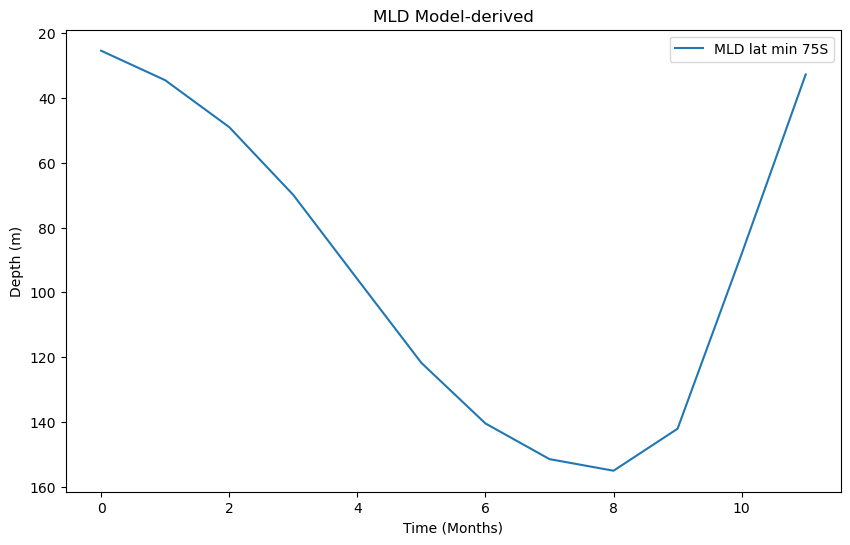

In [52]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot data1
plt.plot(ea_mld, label='MLD lat min 75S')

# Invert y-axis to display depth correctly
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Time (Months)')
plt.ylabel('Depth (m)')
plt.title('MLD Model-derived')
plt.legend()

# Show the plot
plt.show()

### to do for next commit
- compare with calculated MLD using density output
- compare summer vs winter

